https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

RNN과 LSTM 잘 정리돼있음

# Keras를 이용한 RNN 실습

### RNN 개요

- RNN은 히든 노드가 방향을 가진 엣지로 연결돼 순환구조를 이루는(directed cycle) 인공신경망의 한 종류.
- 음성, 문자 등 순차적으로 등장하는 데이터 처리에 적합한 모델
- 역전파(backpropagation)를 수행해 parameter값들을 갱신

### RNN 문제점

RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 vanishing gradient problem 이라고 부른다.

### LSTM 등장

이 문제를 극복하기 위해서 고안된 것이 바로 LSTM입니다. LSTM은 RNN의 히든 state에 cell-state를 추가한 구조
cell state는 일종의 컨베이어 벨트 역할을 합니다. 덕분에 state가 꽤 오래 경과하더라도 그래디언트가 비교적 전파가 잘 되게 됩니다.

## 1. 데이터 준비

In [37]:
import numpy as np

In [2]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

In [3]:
seq[0:1]

['g8']

In [4]:
seq[0:0+3+1]

['g8', 'e8', 'e4', 'f8']

In [5]:
seq[1:1+3+1]

['e8', 'e4', 'f8', 'd8']

함수 생성

In [6]:
# 리스트 자체를 넣으면 안되고..window~
# 1234를 잘라서 5번째 예측, 2345 잘라서 6번째 예측

def seq2dataset(seq, window_size):##어떤 역할을 하는지 생각해보기
    dataset = []
    for i in range(len(seq)-window_size): # len(seq)-window_size : 51 --- 0부터 50까지 돈다
        subset = seq[i:(i+window_size+1)] # len(seq) : 54, window_size : 3 / # seq 에는 음악코드가 나와있음
        dataset.append([code2idx[item] for item in subset])
        # code2idx : 딕셔너리 {key(음악코드) : value(숫자)}
        # value(숫자)를 dataset 리스트에 담는다
    return np.array(dataset) # dataset 리스트를 배열형태로 변환


In [7]:
dataset = seq2dataset(seq, window_size = 3) 
#윈도우사이즈 n : n개의 숫자를 이용해서 다음 숫자를 예측

print(dataset.shape)
print("---------------------")
print(dataset)

(51, 4)
---------------------
[[11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  8]
 [ 1  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]
 [ 9 10 11 11]
 [10 11 11  4]
 [11 11  4 11]
 [11  4 11  9]
 [ 4 11  9  9]
 [11  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  8]
 [ 9 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]
 [11  9  9  2]
 [ 9  9  2  8]
 [ 9  2  8  8]
 [ 2  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  9]
 [ 8  8  9  3]
 [ 8  9  3  9]
 [ 9  3  9  9]
 [ 3  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  4]
 [ 9 10  4 11]
 [10  4 11  9]
 [ 4 11  9  2]
 [11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]
 [11  9  9  2]]


In [8]:
type(dataset)
# ',' 없잖아~!! 리스트 아니징

numpy.ndarray

In [9]:
# dataset = seq2dataset(seq, window_size = 4) 
# #윈도우사이즈 n : n개의 숫자를 이용해서 다음 숫자를 예측

# print(dataset.shape)
# print(dataset)

In [10]:
dataset[0:1, 0:3]

array([[11,  9,  2]])

In [11]:
dataset[0:1, 0:4]

array([[11,  9,  2, 10]])

In [12]:
dataset[0:1, 3]

array([10])

In [13]:
dataset[:, 3]

array([10,  8,  1,  7,  8,  9, 10, 11, 11,  4, 11,  9,  9,  9, 10,  8,  1,
        7,  9, 11, 11,  9,  9,  2,  8,  8,  8,  8,  8,  9,  3,  9,  9,  9,
        9,  9, 10,  4, 11,  9,  2, 10,  8,  1,  7,  9, 11, 11,  9,  9,  2])

## 2. 라이브러리 불러오기

In [14]:
from keras.models import Sequential # 케라스 모델의 기본
from keras.layers import Conv2D # 2D형태로 하겠다
from keras.layers import MaxPooling2D # 2D를 자르고 붙일 때~ 큰 값을 붙이겠다. c.f) Pooling 개념.
from keras.layers import Flatten # CNN (여러 층)으로 쌓은 것을 한층으로 변환
from keras.layers import Dense,LSTM # RNN 할 때 씀

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
from keras.utils import np_utils
# np_utils.to_categorical :::: Converts a class vector (integers) to binary class matrix.
# 정답 갯수만큼 길이가 생성되고, 해당하는 값만 1로 표현해준다.

import keras

In [16]:
x_train=dataset[:,0:4] # 주의 --- '0:4' 의미는 Dataframe의 속성 갯수가 아니라 window size이다. 현재, 속성은 1개임.
y_train=dataset[:,3]

In [17]:
max_idx_value=13
x_train = x_train / float(max_idx_value)
# Scale 하는 것 같네. 

In [18]:
x_train

array([[0.84615385, 0.69230769, 0.15384615, 0.76923077],
       [0.69230769, 0.15384615, 0.76923077, 0.61538462],
       [0.15384615, 0.76923077, 0.61538462, 0.07692308],
       [0.76923077, 0.61538462, 0.07692308, 0.53846154],
       [0.61538462, 0.07692308, 0.53846154, 0.61538462],
       [0.07692308, 0.53846154, 0.61538462, 0.69230769],
       [0.53846154, 0.61538462, 0.69230769, 0.76923077],
       [0.61538462, 0.69230769, 0.76923077, 0.84615385],
       [0.69230769, 0.76923077, 0.84615385, 0.84615385],
       [0.76923077, 0.84615385, 0.84615385, 0.30769231],
       [0.84615385, 0.84615385, 0.30769231, 0.84615385],
       [0.84615385, 0.30769231, 0.84615385, 0.69230769],
       [0.30769231, 0.84615385, 0.69230769, 0.69230769],
       [0.84615385, 0.69230769, 0.69230769, 0.69230769],
       [0.69230769, 0.69230769, 0.69230769, 0.76923077],
       [0.69230769, 0.69230769, 0.76923077, 0.61538462],
       [0.69230769, 0.76923077, 0.61538462, 0.07692308],
       [0.76923077, 0.61538462,

In [19]:
y_train

array([10,  8,  1,  7,  8,  9, 10, 11, 11,  4, 11,  9,  9,  9, 10,  8,  1,
        7,  9, 11, 11,  9,  9,  2,  8,  8,  8,  8,  8,  9,  3,  9,  9,  9,
        9,  9, 10,  4, 11,  9,  2, 10,  8,  1,  7,  9, 11, 11,  9,  9,  2])

In [20]:
y_train=np_utils.to_categorical(y_train)
# np_utils.to_categorical :::: Converts a class vector (integers) to binary class matrix.
# 정답 갯수만큼 길이가 생성되고, 해당하는 값만 1로 표현해준다.
# 정답 갯수만큼 생기는 건 아닌가보네. '0'이 생겨있음.

y_train

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [21]:
y_train[0] # 10 이란 뜻!

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [22]:
type(y_train)

numpy.ndarray

In [23]:
y_train.shape

(51, 12)

In [24]:
y_train.shape[0] # y_train (즉 정답(label) 51개 있단거지!)
y_train.shape[1] # 총 12개의 종류가 있다는 것(이건 확실하지 않음. 0이 끼어져 있음. 종류+1개 만큼 생기는건가?)

12

In [25]:
one_hot_vec_size = y_train.shape[1]
print('one hot encoding vector size is',one_hot_vec_size)

one hot encoding vector size is 12


In [26]:
# 손실 이력 클래스 정의 : 손실을 기록하기 위해 함수 생성

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [27]:
history = LossHistory() 
history.init()

    ※입출력을 모두 연결해주는 Dense 레이어
    
    - Dense 레이어는 입력과 출력을 모두 연결해줍니다. 예를 들어 입력 뉴런이 4개, 출력 뉴런이 8개있다면 총 연결선은 32개(4*8=32) 입니다. 
    각 연결선에는 가중치(weight)를 포함하고 있는데, 이 가중치가 나타내는 의미는 연결강도라고 보시면 됩니다. 
    연결선이 32개이므로 가중치도 32개입니다.
    
    - 가중치가 높을수록 해당 입력 뉴런이 출력 뉴런에 미치는 영향이 크고, 낮을수록 미치는 영향이 적다.


* Dense(8, input_dim=4, init='uniform', activation='relu'))

 - 첫번째 인자 : 출력 뉴런의 수를 설정합니다.
 - input_dim : 입력 뉴런의 수를 설정합니다.
 - init : 가중치 초기화 방법 설정합니다.
 - 'uniform’ : 균일 분포
 - ‘normal’ : 가우시안 분포
 - activation : 활성화 함수 설정합니다.
 - ‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
 - ‘relu’ : rectifier 함수, 은익층에 주로 쓰입니다.
 - ‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.
 - ‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다.

Dense 레이어는 입력 뉴런 수에 상관없이 출력 뉴런 수를 자유롭게 설정할 수 있기 때문에 출력층으로 많이 사용됩니다. 이진 분류문제에서는 0과 1을 나타내는 출력 뉴런이 하나만 있으면 되기 때문에 아래 코드처럼 출력 뉴런이 1개이고, 입력 뉴런과 가중치를 계산한 값을 0에서 1사이로 표현할 수 있는 활성화 함수인 sigmoid을 사용합니다.
    
Dense(1, input_dim=3, activation='sigmoid'))


## 3.  모델 생성 및 실행

In [39]:
model= Sequential()
model.add(Dense(128,input_dim=4,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(one_hot_vec_size,activation='softmax')) #출력 클래스가 몇개인가? 12개(one_hot_vec_size == 12)

Dense 레이어는 보통 출력층 이전의 은닉층으로도 많이 쓰이고, 영상이 아닌 수치자료 입력 시에는 입력층으로도 많이 쓰입니다. 이 때 활성화 함수로 ‘relu’가 주로 사용됩니다. ‘relu’는 학습과정에서 역전파 시에 좋은 성능이 나는 것으로 알려져 있습니다.

In [29]:
# y_train 
# 정답을 나열해두고, 해당하는 것에만 1로 나타냄

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 바이너리가 아니라, categorical : 정답이 여러개

In [31]:
num_epoch=200
model.fit(x_train,y_train,epochs=200,batch_size=10,verbose=2,shuffle=False,callbacks=[history]) # callbaks =[history] 의미!?
#모델 실행하겠다. epochs, batch_size 두 파라미터를 많이 사용한다. callbacks : 이력

Epoch 1/200
 - 0s - loss: 2.4761 - acc: 0.1373
Epoch 2/200
 - 0s - loss: 2.3409 - acc: 0.2157
Epoch 3/200
 - 0s - loss: 2.2446 - acc: 0.3529
Epoch 4/200
 - 0s - loss: 2.1583 - acc: 0.3333
Epoch 5/200
 - 0s - loss: 2.0760 - acc: 0.3333
Epoch 6/200
 - 0s - loss: 2.0006 - acc: 0.3333
Epoch 7/200
 - 0s - loss: 1.9387 - acc: 0.3333
Epoch 8/200
 - 0s - loss: 1.8927 - acc: 0.3333
Epoch 9/200
 - 0s - loss: 1.8592 - acc: 0.3333
Epoch 10/200
 - 0s - loss: 1.8313 - acc: 0.3333
Epoch 11/200
 - 0s - loss: 1.8042 - acc: 0.3333
Epoch 12/200
 - 0s - loss: 1.7764 - acc: 0.3725
Epoch 13/200
 - 0s - loss: 1.7469 - acc: 0.3725
Epoch 14/200
 - 0s - loss: 1.7158 - acc: 0.3922
Epoch 15/200
 - 0s - loss: 1.6857 - acc: 0.3922
Epoch 16/200
 - 0s - loss: 1.6543 - acc: 0.3922
Epoch 17/200
 - 0s - loss: 1.6199 - acc: 0.3922
Epoch 18/200
 - 0s - loss: 1.5869 - acc: 0.3922
Epoch 19/200
 - 0s - loss: 1.5580 - acc: 0.3922
Epoch 20/200
 - 0s - loss: 1.5298 - acc: 0.4314
Epoch 21/200
 - 0s - loss: 1.5004 - acc: 0.4510
E

Epoch 171/200
 - 0s - loss: 0.4443 - acc: 0.8824
Epoch 172/200
 - 0s - loss: 0.4410 - acc: 0.8824
Epoch 173/200
 - 0s - loss: 0.4371 - acc: 0.8824
Epoch 174/200
 - 0s - loss: 0.4342 - acc: 0.8824
Epoch 175/200
 - 0s - loss: 0.4308 - acc: 0.8824
Epoch 176/200
 - 0s - loss: 0.4274 - acc: 0.8824
Epoch 177/200
 - 0s - loss: 0.4239 - acc: 0.8824
Epoch 178/200
 - 0s - loss: 0.4203 - acc: 0.8824
Epoch 179/200
 - 0s - loss: 0.4173 - acc: 0.8824
Epoch 180/200
 - 0s - loss: 0.4141 - acc: 0.8824
Epoch 181/200
 - 0s - loss: 0.4102 - acc: 0.8824
Epoch 182/200
 - 0s - loss: 0.4072 - acc: 0.8824
Epoch 183/200
 - 0s - loss: 0.4041 - acc: 0.8824
Epoch 184/200
 - 0s - loss: 0.4003 - acc: 0.8824
Epoch 185/200
 - 0s - loss: 0.3971 - acc: 0.8824
Epoch 186/200
 - 0s - loss: 0.3939 - acc: 0.8824
Epoch 187/200
 - 0s - loss: 0.3903 - acc: 0.8824
Epoch 188/200
 - 0s - loss: 0.3876 - acc: 0.8824
Epoch 189/200
 - 0s - loss: 0.3842 - acc: 0.8824
Epoch 190/200
 - 0s - loss: 0.3814 - acc: 0.8824
Epoch 191/200
 - 0s 

## 4. 시각화

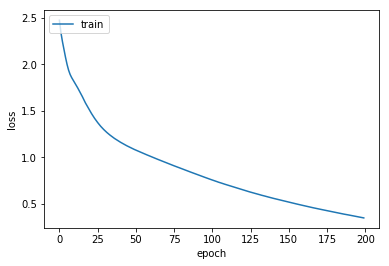

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## 5. 검증

In [33]:
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

51/51 [==============================] - 0s 665us/step
acc: 90.20%


In [34]:
pred_count = 50 # 최대 예측 개수 정의


seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

In [35]:
for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'g8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8']


In [36]:
# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in,(1,4)) #batch_size,속성수
    pred_out = model.predict(sample_in) # X_test 넣어야지~
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

full song prediction :  ['g8', 'e8', 'e4', 'f8', 'f8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8']
